# Testing Naive Bayes and LinearSVC

In this notebook, we use a method of supervised learning to attempt and classify patents into predefined categories. To begin, we load in the data, then preprocess it. As patent classifications can be very niche, we combined the ipc_section and ipc_class into one column. We addtionally subset to only predict with classes that have more than fifty observations. Overall, the goal is to predict this classification based on the patent title and abstract.

In [ ]:
# Load in libraries and data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv(
    "/Users/lilahduboff/Documents/Duke NLP/Final Project/Natural_Language_Processing_Final_Project/Data/subsidiary_patents.csv"
)

#check the length, may need git lfs
df.shape

(99106, 13)

In [18]:
df.sample(20)

,SYMBOL,SUBSIDIARY,patent_id,patent_title,patent_date,patent_year,patent_type,withdrawn,assignee_organization,ipc_sections,ipc_classes,ipc_subclasses,patent_abstract
67621,PG,The Procter & Gamble Company,D673857,Container,2013-01-08,2013,design,False,The Procter & Gamble Company,NaN,NaN,NaN,NaN
18952,JNJ,Ethicon,10022568,Devices and techniques for cutting and coagula...,2018-07-17,2018,utility,False,"Ethicon, Inc.",A;B;G;H,01;05;06;61,B;L;N,Various embodiments are directed to a method o...
54592,PG,The Procter & Gamble Company,12274606,Wearable article comprising an elastic belt la...,2025-04-15,2025,utility,False,The Procter & Gamble Company,A;B,32;61,B;F,A wearable article comprising an elastic lamin...
41368,NKE,Nike Inc.,D1037634,Shoe,2024-08-06,2024,design,False,"NIKE, Inc.",NaN,NaN,NaN,NaN
80221,VZ,Verizon Patent and Licensing Inc.,9665709,Methods and systems for determining a complian...,2017-05-30,2017,utility,False,Verizon Patent and Licensing Inc.,G,06,F,An exemplary method includes an application ma...
91956,HON,UOP LLC,4364849,Fluid catalyst regeneration process and apparatus,1982-12-21,1982,utility,False,UOP LLC,B;C,01;10,G;J,A catalyst regeneration process and apparatus ...
56501,PG,The Procter & Gamble Company,5207933,Liquid fabric softener with insoluble particle...,1993-05-04,1993,utility,False,The Procter & Gamble Company,D,06,M,"Fabric softening compositions, preferably in l..."
25762,MMM,"KCI Licensing, Inc.",10004645,"Radio opaque, reduced-pressure manifolds, syst...",2018-06-26,2018,utility,False,"KCI Licensing, Inc.",A,61,B;F;M,A method of manufacturing a manifold pad that ...
34042,MRK,Acceleron Pharma Inc.,10093707,Antagonists of activin-ActRIIa and uses for in...,2018-10-09,2018,utility,False,ACCELERON PHARMA INC.,A;C,07;61,K,"In certain aspects, the present invention prov..."
90239,HON,Intelligrated,11518629,Measurement system on a conveyor,2022-12-06,2022,utility,False,"INTELLIGRATED HEADQUARTERS, LLC",B;G,1;25;65,G;J;N,A measurement system used in conjunction with ...


## Basic EDA and adjustments to data

In this section, I will check for missing values, explore and modify data types, and save a subset with the 500 most recent patents to a new csv for further preprocessing 

In [ ]:
# See how many rows are null
#if the abstract is null, we can't use it for classification
print(df["patent_abstract"].isnull().sum())

16304


In [ ]:
# drop rows with null abstracts
df = df.dropna(subset=["patent_abstract"])

In [ ]:
#likely will need to convert some datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82802 entries, 0 to 99105
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   SYMBOL                 82802 non-null  object
 1   SUBSIDIARY             82802 non-null  object
 2   patent_id              82802 non-null  object
 3   patent_title           82802 non-null  object
 4   patent_date            82802 non-null  object
 5   patent_year            82802 non-null  int64 
 6   patent_type            82802 non-null  object
 7   withdrawn              82802 non-null  bool  
 8   assignee_organization  82802 non-null  object
 9   ipc_sections           82782 non-null  object
 10  ipc_classes            82782 non-null  object
 11  ipc_subclasses         82782 non-null  object
 12  patent_abstract        82802 non-null  object
dtypes: bool(1), int64(1), object(11)
memory usage: 8.3+ MB


In [ ]:
#converting patent date to datetime so we can use it to filter
df["patent_date"] = pd.to_datetime(df["patent_date"], errors="coerce")

In [ ]:
# select the most recent 500 patents for each subsidiary

df = df.sort_values(["SUBSIDIARY", "patent_date"], ascending=[True, False])
top500_subset = df.groupby("SUBSIDIARY").head(500)

top500_subset.shape

(21644, 13)

In [ ]:
#brief look at the subset
top500_subset.head()

,SYMBOL,SUBSIDIARY,patent_id,patent_title,patent_date,patent_year,patent_type,withdrawn,assignee_organization,ipc_sections,ipc_classes,ipc_subclasses,patent_abstract
25759,MMM,"3M COGENT, INC.",8411916,Bio-reader device with ticket identification,2013-04-02,2013,utility,False,"3M Cogent, Inc.",G,06,K,A method and device for determining a concentr...
25758,MMM,"3M COGENT, INC.",8379982,System and method for fast biometric pattern m...,2013-02-19,2013,utility,False,"3M Cogent, Inc.",G,06,K,A method and system for matching two biometric...
25757,MMM,"3M COGENT, INC.",8275179,Apparatus for capturing a high quality image o...,2012-09-25,2012,utility,False,"3M Cogent, Inc.",G,06,K,An apparatus for capturing the image of a wet/...
25756,MMM,"3M COGENT, INC.",8254728,Method and apparatus for two dimensional image...,2012-08-28,2012,utility,False,"3M Cogent, Inc.",G,06,K,"In one embodiment, the present invention is a ..."
25755,MMM,"3M COGENT, INC.",8131477,Method and device for image-based biological d...,2012-03-06,2012,utility,False,"3M Cogent, Inc.",G,01;06,F;K;N,A device and method for determining a concentr...


In [25]:
# export to data folder
top500_subset.to_csv("data/top500_patents.csv", index=False)

## Actual Preprocessing
Now that we have our finalized data, we will combine the section and class columns, as well as the title and abstract columns, to simplify our predictions. We will also drop any patents classifications that have under 50 observations. As patent classifications have be very niche, we expect to see many patents that have multiple classifications but only 1-2 observations. This doesn't typically perform well for machine learning/natural language processing, so we will have to drop them. To make the text easier to classify, we will additionally convert all text to lowercase, and remove stopwords like "the", "and", etc. 

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")

stop = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    t = " ".join([lemmatizer.lemmatize(word) for word in t.split() if word not in stop])
    return t

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilahduboff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lilahduboff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [49]:
# load in new subset
df_subset = pd.read_csv("data/top500_patents.csv")

# combine section and class, then clean text
df_subset["Combined_ipc_clean"] = (
    df_subset["ipc_sections"] + "_" + df_subset["ipc_classes"].astype(str)
)

# combine title and abstract for easier classification
df_subset["text_clean"] = (
    (df_subset["patent_title"] + ": " + df_subset["patent_abstract"])
    .astype(str)
    .apply(clean_text)
)

In [50]:
df_subset["Combined_ipc_clean"].value_counts()

Combined_ipc_clean
A_61                2483
G_06                2171
G_6                 1651
H_04                1244
G;H_4;6              731
                    ... 
A;B;G_1;25;43;6        1
A;G_1;16;4;43;63       1
A;G_16;41;61           1
A_41;44                1
B;H_5;60               1
Name: count, Length: 1735, dtype: int64

In [52]:
# drop under 50 observations
df_subset = df_subset.groupby("Combined_ipc_clean").filter(lambda x: len(x) >= 50)

H_04 and H_4
G_1 and G_01
B_1 and B_01

DUPLICATES

In [ ]:
import re

def normalize_ipc_label(label: str) -> str:
    # 1. Handle composite labels (e.g., H;G:06) by taking the first section
    if ';' in label:
        label = label.split(';')[0]
    
    # 2. Extract the IPC Section (A, B, C...)
    match = re.search(r'^[A-H]', label) # IPC sections go from A to H
    if match:
        return match.group(0)
    
    return "UNKNOWN"

# Examples using the function:
# normalize_ipc_label('A_01')     # -> 'A'
# normalize_ipc_label('A:C:07')   # -> 'A'
# normalize_ipc_label('G;H:04')   # -> 'G' (first section)

## Train and test Naive Bayes


In [ ]:
# Inputs and labels
X_bayes = df_subset["text_clean"]
y_bayes = df_subset["Combined_ipc_clean"]

X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(
    X_bayes, y_bayes, test_size=0.20, stratify=y, random_state=42
)

# Build model
class_model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=50000)),
        ("nb", ComplementNB()),
    ]
)

# Train
class_model.fit(X_train_bayes, y_train_bayes)

# Evaluate
preds = class_model.predict(X_test_bayes)
print("IPC Class Accuracy:", accuracy_score(y_test_bayes, preds))
print(classification_report(y_test_bayes, preds))

IPC Class Accuracy: 0.6490445859872611
              precision    recall  f1-score   support

A;C_07;12;61       0.00      0.00      0.00        13
   A;C_07;61       0.43      0.79      0.56       102
    A;C_61;7       0.67      0.65      0.66        74
    A;G_6;63       1.00      0.09      0.17        11
        A_23       1.00      0.83      0.91        12
        A_43       0.89      0.98      0.93        51
        A_46       0.50      0.13      0.21        15
     A_46;61       0.67      0.29      0.40        14
        A_61       0.73      0.91      0.81       497
        A_63       0.89      0.89      0.89        44
       B;C_1       0.54      0.70      0.61        10
    B;C_1;10       0.55      0.23      0.32        26
     B;C_1;7       0.50      0.15      0.23        20
    B;G_6;60       0.00      0.00      0.00        10
        B_01       0.60      0.14      0.22        22
         B_1       0.60      0.55      0.57        11
        B_26       0.87      0.71      0.7

/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


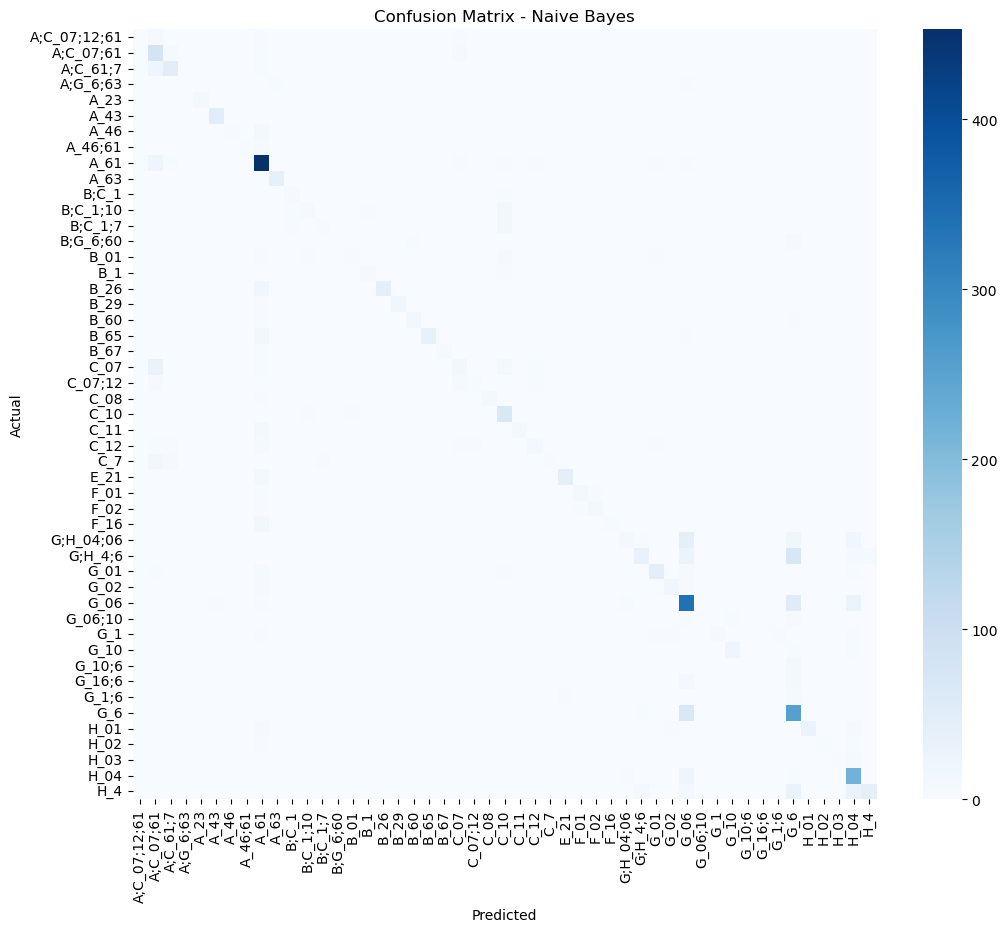

In [ ]:
# Predictions
y_pred = class_model.predict(X_test_bayes)

# Confusion matrix
cm = confusion_matrix(y_test_bayes, y_pred, labels=class_model.classes_)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=class_model.classes_,
    yticklabels=class_model.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

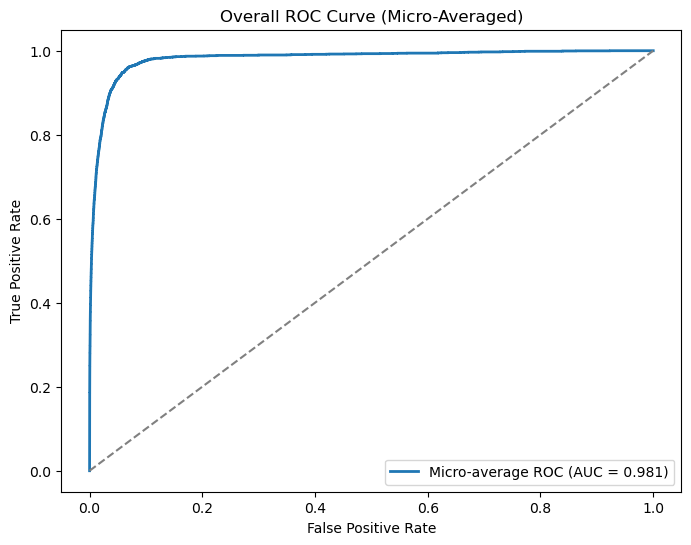

Overall AUC ROC: 0.9814316165632142


In [ ]:
# Get the classes
classes = sorted(y_test_bayes.unique())

# Binarize true labels
y_test_bin = label_binarize(y_test_bayes, classes=classes)

# Predict probability estimates
y_proba = class_model.predict_proba(X_test_bayes)

# Compute micro-average ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"Micro-average ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve (Micro-Averaged)")
plt.legend()
plt.show()

print("Overall AUC ROC:", roc_auc)

## Train and Test a LinearSVC

In [71]:
# Define X and y
X_svc = df_subset["text_clean"]
y_svc = df_subset["Combined_ipc_clean"]

# Train/test split
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(
    X_svc, y_svc, test_size=0.2, stratify=y_svc, random_state=42
)

# LinearSVC model
model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words="english")),
        ("clf", LinearSVC(class_weight="balanced")),
    ]
)

# Fit model
model.fit(X_train_svc, y_train_svc)

# Predictions
y_pred = model.predict(X_test_svc)

# Evaluation
print("Accuracy:", accuracy_score(y_test_svc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_svc, y_pred))

Accuracy: 0.7057324840764331

Classification Report:
               precision    recall  f1-score   support

A;C_07;12;61       0.26      0.54      0.35        13
   A;C_07;61       0.61      0.71      0.65       102
    A;C_61;7       0.71      0.76      0.73        74
    A;G_6;63       0.70      0.64      0.67        11
        A_23       1.00      0.92      0.96        12
        A_43       0.89      0.96      0.92        51
        A_46       0.82      0.60      0.69        15
     A_46;61       0.46      0.79      0.58        14
        A_61       0.93      0.87      0.90       497
        A_63       0.87      0.91      0.89        44
       B;C_1       0.73      0.80      0.76        10
    B;C_1;10       0.46      0.42      0.44        26
     B;C_1;7       0.58      0.55      0.56        20
    B;G_6;60       0.42      0.50      0.45        10
        B_01       0.39      0.41      0.40        22
         B_1       0.40      0.36      0.38        11
        B_26       0.92    

In [70]:
import numpy as np

# Meshgrid for plotting
x_min, x_max = X_test_svc[:, 0].min() - 1, X_test_svc[:, 0].max() + 1
y_min, y_max = X_test_svc[:, 1].min() - 1, X_test_svc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(
    X_test_svc[:, 0],
    X_test_svc[:, 1],
    c=y_test_svc,
    cmap=plt.cm.coolwarm,
    edgecolors="k",
)
plt.show()

KeyError: 'key of type tuple not found and not a MultiIndex'